## I. Introduction

In this notebook we design simple neural networks from scratch in order to compute European call price. We use the Black & Scholes framework and we use the closed form solution provided by the model as a benchmark for training/evaluating our networks.

We will see that the activation function choice has a big impact on network performance. Sigmoid function does not perform well. RELU function performs better but lacks of regularity/smoothing that can be partially fixed with a higher number of layers. ELU function is more smooth that RELU but its negative part leads so significant error when time to maturity is short.

We note that the use of time to maturity as a parameter (instead of time alone) has helped to improve networks performances significantly. Instead of pricing the call price directly we price the time value, because the intrinsic value is deterministic and the payoff is then capped with ATM time value.

Several tests has shown that a learning rate of 0.05 as well as 6 hidden layers with 30 units in each allows to reach good performance. However, as the point here was to build a simple network from scratch we did not test advanced features as dropout, etc.

Overall perfomance is quite good, time value is well predicted for almost every maturity. Difficulties arise when the time to marutity becomes very short (less than 0.05) due to strong variations of time value (strong second orders greeks).

In [1]:
#%tensorflow_version 1.x
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

C:\Users\Johan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Johan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Johan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Johan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## II. Neural Network construction

We assume the learning problem is:
$$\min_{\theta} \left\|\mathcal{NN}_{\theta}\left(X\right)-Y\right\|_2^2$$
where $X\in\mathcal{M}_{n,d}$, $Y\in\mathbb{R}^n$ and $\mathcal{NN}$ is a neural network parametrized by $\theta$.

Below we tested several networks with variations in the number of hidden layers, hidden units per hidden layer and learning rates. Optimal parameters were finally chosen: respectively 4, 20 and 0.01. Several activation functions for the hidden units are tested below. We will keep a one-dimensional output as the price of the call we want to price.

We implement a function `construct_densenn_graph(input_dim, output_dim, num_hidden_layers, num_hidden_units, activation, final_activation)` which will construct the graph using tensorflow and return it.

### Graph construction

In [2]:
def construct_densenn_graph(input_dim, output_dim, num_hidden_layers, num_hidden_units, activation,final_activation): 
    # Building a graph which will be run during the execution phase.
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(tf.float32, shape = (None, input_dim), name = 'X')
        Y = tf.placeholder(tf.float32, shape = (None, output_dim), name = 'Y')
        learningRate = tf.placeholder(tf.float32, shape = [],name = 'learningRate')
        # Initialization.
        weights, biases = [], []
        for i in range(num_hidden_layers+1): #weights and biais matrix construction
            dim_prev = input_dim if i==0 else num_hidden_units
            num_units = output_dim if i==num_hidden_layers else num_hidden_units
            weights.append(tf.get_variable('weights/W'+str(i), 
                                            shape=(num_units, dim_prev), 
                                            dtype=tf.float32, 
                                            initializer=tf.random_normal_initializer(mean=0, stddev=np.sqrt(2)*np.sqrt(2/(num_units+dim_prev)) ))) #optimal initialization, see ML book
            biases.append(tf.get_variable('biases/b'+str(i), shape=(num_units, 1), 
                                            dtype=tf.float32, 
                                            initializer=tf.zeros_initializer()))
        out = tf.transpose(X)
        # Building the fundation of the network.
        for i in range(num_hidden_layers+1): #output construction
            if i < num_hidden_layers: #activation function for the hidden layers
                if activation == None:
                    out = tf.matmul(weights[i], out)+biases[i]
                else:
                    out = activation(tf.matmul(weights[i], out)+biases[i])
            else: #activation function for the output layer
                if final_activation == None:
                    out = tf.matmul(weights[i], out)+biases[i]
                else:
                    out = final_activation(tf.matmul(weights[i], out)+biases[i])
        # Getting the ouput of the network.
        out = tf.identity(out, name='out')
        # Using the MSE loss function.
        loss_fct = tf.reduce_mean((tf.transpose(out) - Y)**2, name='loss_fct')  # compute loss function
        # Gradient descent optimizer.
        gradient_step = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(loss_fct, var_list=weights+biases, name='gradient_step') # compute gradient descent and update weights and biases
    return g

### Auxiliary functions

We construct the function `eval_densenn(g, X_in, weights_fitted, biases_fitted)` which, given fitted values of the weights and biases, will evaluate the output value of the dense network corresponding to the input `X` **using TensorFlow**.

In [46]:
def eval_densenn(g, X_in, weights_fitted, biases_fitted):
    X = g.get_tensor_by_name('X:0')
    out = g.get_tensor_by_name('out:0')
    weights = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='weights')
    biases = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='biases')
    feed_dict = {k: v for k, v in zip([X,]+weights+biases, [X_in,]+weights_fitted+biases_fitted)}
    with tf.Session(graph=g) as sess:
        out = sess.run(out, feed_dict=feed_dict)
    return out.T

We now implement a function `fit_densenn_model(g, X_train, Y_train, eps, max_iter, learning_rate)` to train the model.

In [4]:
def fit_densenn_model(g, X_train, Y_train, eps, max_iter,learning_rate):
    X = g.get_tensor_by_name('X:0')
    Y = g.get_tensor_by_name('Y:0')
    learningRate = g.get_tensor_by_name('learningRate:0')

    gradient_step = g.get_operation_by_name('gradient_step')
    loss_fct = g.get_tensor_by_name('loss_fct:0')
    weights = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='weights')
    biases = g.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='biases')

    #saver = tf.train.Saver()

    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        err = np.inf
        i = 0

        while (err >= eps) and (i < max_iter):
            sess.run(gradient_step, feed_dict={X: X_train, Y: Y_train, learningRate: learning_rate})
            err = sess.run(loss_fct, feed_dict={X: X_train, Y: Y_train})
            i += 1
            if i%100==0:
                learning_rate *= 0.95                  # decreasing learning rate every 100 epochs
        weights_fitted = sess.run(weights)
        biases_fitted = sess.run(biases)

    return weights_fitted, biases_fitted

In [5]:
# Functions to normalize / "de-normalize"
def denormalize(Z,mean,std):
    return( Z*std + mean )

def normalize(Z,mean,std):
    return( (Z-mean)/std )

## III. Testing the networks

We fix the following parameters:
- interest rate r
- volatility sigma
- strike K
- maturity T

We look for the call price given the underlying level at time $t$. So our network will have 2 inputs: $S_t$ and time to maturity $T-t$.

### Call price formula

We implement a function to compute the call price in the Black & Scholes framework.

In [6]:
from scipy.stats import norm

In [7]:
def CallPrice(S, K, r, sigma, ttm):
    
    #ttm = T - t
    if ttm < 0:
        return 0.
    elif ttm == 0.:
        return np.maximum(S - K, 0.)

    vol = sigma * np.sqrt(ttm)

    d_minus = np.log(S / K) + (r - 0.5 * sigma**2) * ttm
    d_minus /= vol

    d_plus = d_minus + vol

    res = S * norm.cdf(d_plus)
    res -= K * np.exp(-r * ttm) * norm.cdf(d_minus)
    
    res -= max(0, S-K)

    return res

We fix the parameters:

In [257]:
r = 0.05
sigma = 0.20
T = 1.0
K = 100.0

Generating the sample to train and test our network:

In [258]:
ttm = T*np.random.sample(size=(100000, 1)) # we evaluate the call at anytime between 0 and the maturity
S = 200*(np.random.sample(size=(100000, 1))) # the underlying can take any value from 0 to 200

In [259]:
X_all = np.array([ttm,S]).T
X_train = X_all[0,:98000, :]
X_valid = X_all[0,98000:99000, :]
X_test = X_all[0,99000:, :]

In [260]:
# Normalizing the inputs
mean_X = [np.mean(X_train[:,0]), np.mean(X_train[:,1])]
std_X = [np.std(X_train[:,0]), np.std(X_train[:,1])]

X_train = np.array([normalize(X_train[:,0], mean_X[0], std_X[0]) , normalize(X_train[:,1], mean_X[1], std_X[1])] ).transpose()
X_valid = np.array([normalize(X_valid[:,0], mean_X[0], std_X[0]) , normalize(X_valid[:,1], mean_X[1], std_X[1])] ).transpose()
X_test = np.array([normalize(X_test[:,0], mean_X[0], std_X[0]) , normalize(X_test[:,1], mean_X[1], std_X[1])] ).transpose()

In [261]:
Y_all = []
for i in range(0,100000):
    Y_all.append(CallPrice(X_all[0,i, 1], K, r, sigma, X_all[0,i, 0]))

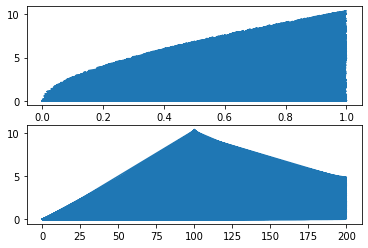

In [262]:
#checking output
plt.figure()
plt.title('Time value depending on time-to-maturity (above) and spot price (below)')
plt.subplot(211)
plt.plot(X_all[0,:, 0],Y_all)
plt.subplot(212)
plt.plot(X_all[0,:, 1],Y_all)

In [263]:
Y_all = np.array([np.array(Y_all)]).T
Y_train = Y_all[:98000, :]
Y_valid = Y_all[98000:99000, :]
Y_test = Y_all[99000:, :]

In [264]:
# Normalizing the outputs
mean_Y = np.mean(Y_train)
std_Y = np.std(Y_train)

Y_train = normalize(Y_train, mean_Y, std_Y)
Y_valid = normalize(Y_valid, mean_Y, std_Y)
Y_test = normalize(Y_test, mean_Y, std_Y)

### Tunning the network

Considering the shape of the theoretical price we choose Elu function for activation function on hidden layers and no final activation function.

We go through a grid to find the optimal parameters among the number of hidden layers, the number of units per layer and the learning rate.

In [265]:
import time

In [282]:
#nb_layer_list = [int(x) for x in np.linspace(3, 7, num = 5)]
nb_unit_list = [int(x) for x in np.linspace(10, 30, num = 5)]
learning_rate_list = [x/100 for x in np.linspace(0.5, 5, num = 10)] #

activation_list = [tf.nn.elu, tf.nn.relu, tf.nn.sigmoid]
final_activation = None

eps = 1e-8
max_iter = 1000
best_valid_err = np.inf
hist = []

In [283]:
for nb_layer in nb_layer_list:
    print('nb layer :', nb_layer)
    for nb_unit in nb_unit_list:
        for learning_rate in learning_rate_list:
            for activation in activation_list :
                call_nn = construct_densenn_graph(X_train.shape[1],Y_train.shape[1], nb_layer, nb_unit, activation, final_activation)
                weights_fitted, biases_fitted = fit_densenn_model(call_nn, X_train[:50000,:], Y_train[:50000,:], eps, max_iter, learning_rate)
                t = time.time()
                valid_err = np.mean((eval_densenn(call_nn, X_valid, weights_fitted, biases_fitted) - Y_valid)**2)
                hist.append([nb_layer, nb_unit, learning_rate, valid_err, time.time()-t])
                #print(nb_layer,nb_unit)
                if valid_err < best_valid_err:
                    best_valid_err = valid_err
                    best_weights_fitted, best_biases_fitted = weights_fitted, biases_fitted
                    best_learning_rate = learning_rate
                    best_call_nn = call_nn
                    print('Best model for now: nb layer = %d, nb unit = %d, learning rate = %.3f, activation = %s'%(nb_layer,nb_unit,learning_rate,activation))
                
print('Best learning rate:',best_learning_rate,'Best validation error', best_valid_err)

nb layer : 6
Best model for now: nb layer = 6, nb unit = 23, learning rate = 0.050, activation = <function relu at 0x00000288EB79C558>
Best model for now: nb layer = 6, nb unit = 25, learning rate = 0.050, activation = <function relu at 0x00000288EB79C558>
Best model for now: nb layer = 6, nb unit = 30, learning rate = 0.050, activation = <function relu at 0x00000288EB79C558>
Best learning rate: 0.05 Best validation error 0.00024078237013227443


In [320]:
best_call_nn = construct_densenn_graph(X_train.shape[1],Y_train.shape[1], 6, 30, tf.nn.relu, None)
best_weights_fitted, best_biases_fitted = fit_densenn_model(best_call_nn, X_train, Y_train, eps, max_iter, 0.05) #[:50000,:]

We now represent on graphs the network results for several valuation times.

In [338]:
ttm = 0.25 # Valuation at time 0.75 year
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T
_x_norm = np.array([normalize(_x[:,0], mean_X[0], std_X[0]) , normalize(_x[:,1], mean_X[1], std_X[1])] ).transpose()

In [339]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1],K, r, sigma, _x[i,0]))
true_y = np.array(true_y)

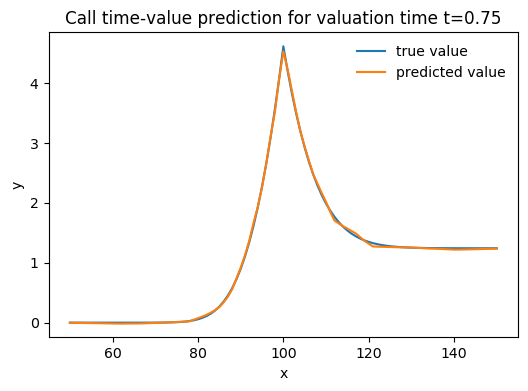

In [340]:
predicted_y_nn = eval_densenn(best_call_nn, _x_norm, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], denormalize(predicted_y_nn,mean_Y,std_Y), label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call time-value prediction for valuation time t=%.2f'%(1-ttm))
plt.legend(frameon=False);

In [341]:
ttm = 0.99 # Valuation after inception
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T
_x_norm = np.array([normalize(_x[:,0], mean_X[0], std_X[0]) , normalize(_x[:,1], mean_X[1], std_X[1])] ).transpose()

In [342]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], K, r, sigma, _x[i,0]))
true_y = np.array(true_y)

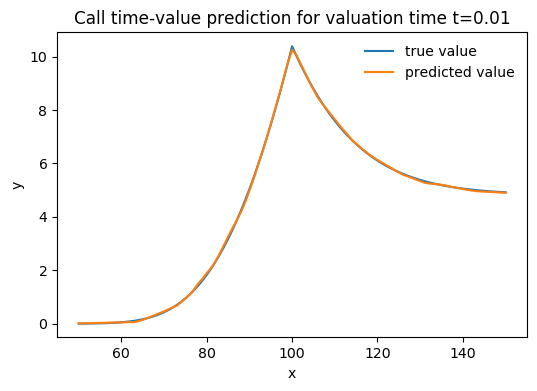

In [343]:
predicted_y_nn = eval_densenn(best_call_nn, _x_norm, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], denormalize(predicted_y_nn,mean_Y,std_Y), label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call time-value prediction for valuation time t=%.2f'%(1-ttm))
plt.legend(frameon=False);

In [361]:
ttm = 0.01 # Valuation just before maturity
_x = np.array([np.ones(101)*ttm,np.linspace(50, 150, 101)]).T
_x_norm = np.array([normalize(_x[:,0], mean_X[0], std_X[0]) , normalize(_x[:,1], mean_X[1], std_X[1])] ).transpose()

In [362]:
true_y = []
for i in range(0,101):
    true_y.append(CallPrice(_x[i,1], K, r, sigma, _x[i,0]))
true_y = np.array(true_y)

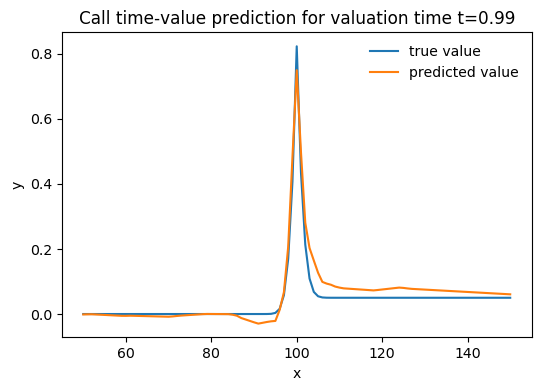

In [363]:
predicted_y_nn = eval_densenn(best_call_nn, _x_norm, best_weights_fitted, best_biases_fitted).ravel()
plt.figure(dpi=101)
plt.plot(_x[:,1], true_y, label='true value')
plt.plot(_x[:,1], denormalize(predicted_y_nn,mean_Y,std_Y), label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Call time-value prediction for valuation time t=%.2f'%(1-ttm))
plt.legend(frameon=False);

Below we represent the results of the network on the test sample.

In [350]:
test_y_nn = eval_densenn(best_call_nn, X_test, best_weights_fitted, best_biases_fitted).ravel()
test_err = np.mean((test_y_nn - Y_test[:,0])**2)
print('MSE on test sample:',test_err)

MSE on test sample: 8.595599866754997e-05


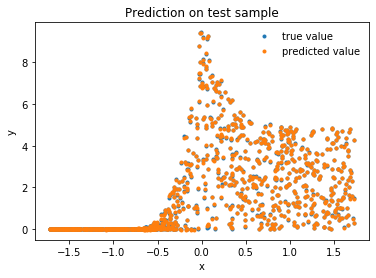

In [351]:
plt.plot(X_test[:,1],denormalize(Y_test,mean_Y,std_Y),'.',label='true value')
plt.plot(X_test[:,1],denormalize(test_y_nn,mean_Y,std_Y),'.',label='predicted value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction on test sample')
plt.legend(frameon=False);

## IV. Opening

We could generate call prices from a more sophisticated model (stochastic volatility and interest rate) and Monte Carlo simulations, then train our networks using more input parameters: time to maturity, spot price, strike, interest rates/volatility process parameters. This would require a bigger and more complex network and a greater computation power.

Usually, prices are not computing directly by neural networks. You can find on another repository an application of neural networks to replicate implied volatility surface from a SABR model. This help to reduce significantly the pricing time when computing complex prices with Monte Carlo techniques (as for exotic derivatives).